In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/DL/license-plate-dataset-master.zip > out.txt

In [3]:
!ls
!ls license-plate-dataset-master
!ls license-plate-dataset-master/dataset
!ls license-plate-dataset-master/dataset/train
!ls license-plate-dataset-master/dataset/train/images
!ls license-plate-dataset-master/dataset/train/annots

drive  license-plate-dataset-master  out.txt  sample_data
dataset  LICENSE  README.md
train  valid
annots	images
'dayride_type1_001.mp4#t=1054.jpg'  'dayride_type1_001.mp4#t=539.jpg'
'dayride_type1_001.mp4#t=1056.jpg'  'dayride_type1_001.mp4#t=540.jpg'
'dayride_type1_001.mp4#t=1057.jpg'  'dayride_type1_001.mp4#t=553.jpg'
'dayride_type1_001.mp4#t=1059.jpg'  'dayride_type1_001.mp4#t=557.jpg'
'dayride_type1_001.mp4#t=1060.jpg'  'dayride_type1_001.mp4#t=558.jpg'
'dayride_type1_001.mp4#t=1062.jpg'  'dayride_type1_001.mp4#t=561.jpg'
'dayride_type1_001.mp4#t=1063.jpg'  'dayride_type1_001.mp4#t=564.jpg'
'dayride_type1_001.mp4#t=1071.jpg'  'dayride_type1_001.mp4#t=56.jpg'
'dayride_type1_001.mp4#t=1072.jpg'  'dayride_type1_001.mp4#t=570.jpg'
'dayride_type1_001.mp4#t=1073.jpg'  'dayride_type1_001.mp4#t=580.jpg'
'dayride_type1_001.mp4#t=1075.jpg'  'dayride_type1_001.mp4#t=582.jpg'
'dayride_type1_001.mp4#t=1077.jpg'  'dayride_type1_001.mp4#t=585.jpg'
'dayride_type1_001.mp4#t=1078.jpg'  'dayride_typ

In [4]:
import os
import re
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from PIL import Image
import xml.etree.ElementTree as ET
from torch.autograd import Variable
from scipy.optimize import linear_sum_assignment


In [5]:
dataset_path='license-plate-dataset-master/dataset/'

In [6]:
def show_image(img, targets=None, founds=None, show_gt=True):
    plt.figure(figsize=(20, 20))
    plt.imshow(img.permute(1, 2, 0))

    ax = plt.gca()
    if show_gt and targets is not None:
        for target in targets:
            xmin = target[0]
            ymin = target[1]
            xmax = target[2]
            ymax = target[3]
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor='cyan',
                fill=False
            )
            ax.add_patch(rect)

    if founds is not None:
        for found in founds:
            xmin = found[0]
            ymin = found[1]
            xmax = found[2]
            ymax = found[3]
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor='red',
                fill=False
            )
            ax.add_patch(rect)

    plt.show()

def get_targets(path):
    targets = []
    tree = ET.parse(path)
    root = tree.getroot()

    for obj in root.findall('object'):
        xmin = float(obj.find('bndbox/xmin').text)
        ymin = float(obj.find('bndbox/ymin').text)
        xmax = float(obj.find('bndbox/xmax').text)
        ymax = float(obj.find('bndbox/ymax').text)
        targets.append({
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax,
        })
    
    return targets

In [7]:
class LicensePlateDataset(Dataset):

    def __init__(self, path, transform):
        self.path = path
        self.images_path = os.path.join(self.path, 'images')
        self.annots_path = os.path.join(self.path, 'annots')
        self.transform = transform
        self.items = []

        regex = re.compile(r'(.+)\.jpg')
        for filename in os.listdir(self.images_path):
            match = regex.match(filename)
            if match:
              self.items.append(match.groups()[0])

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items[idx]
        img_path = os.path.join(self.images_path, '%s.jpg' % item)
        ann_path = os.path.join(self.annots_path, '%s.xml' % item)
        img = self.transform(Image.open(img_path).convert('RGB'))
        boxes = get_targets(ann_path)
        targets = []
        for box in boxes:
            targets.append(torch.tensor([box['xmin'], box['ymin'], box['xmax'], box['ymax']]))
        targets = torch.stack(targets).float()
        return img, targets

In [8]:
# class AddGaussianNoise(object):
#     def __init__(self, mean=0., std=1.):
#         self.std = std
#         self.mean = mean
        
#     def __call__(self, tensor):
#         X = tensor + torch.randn(tensor.size()) * self.std + self.mean
#         X -= X.min()
#         X /= X.max()
#         return X
    
#     def __repr__(self):
#         return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomOrder([
        torchvision.transforms.RandomApply([torchvision.transforms.ColorJitter(hue=.03, saturation=.03)], p=0.5),
        torchvision.transforms.RandomApply([torchvision.transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.01, 1.1))], p=0.5),
        # torchvision.transforms.RandomApply([AddGaussianNoise(0, 0.1)], p=0.5),
    ]),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_dataset = LicensePlateDataset(os.path.join(dataset_path, 'train'), transform=train_transforms)
val_dataset = LicensePlateDataset(os.path.join(dataset_path, 'valid'), transform=val_transforms)

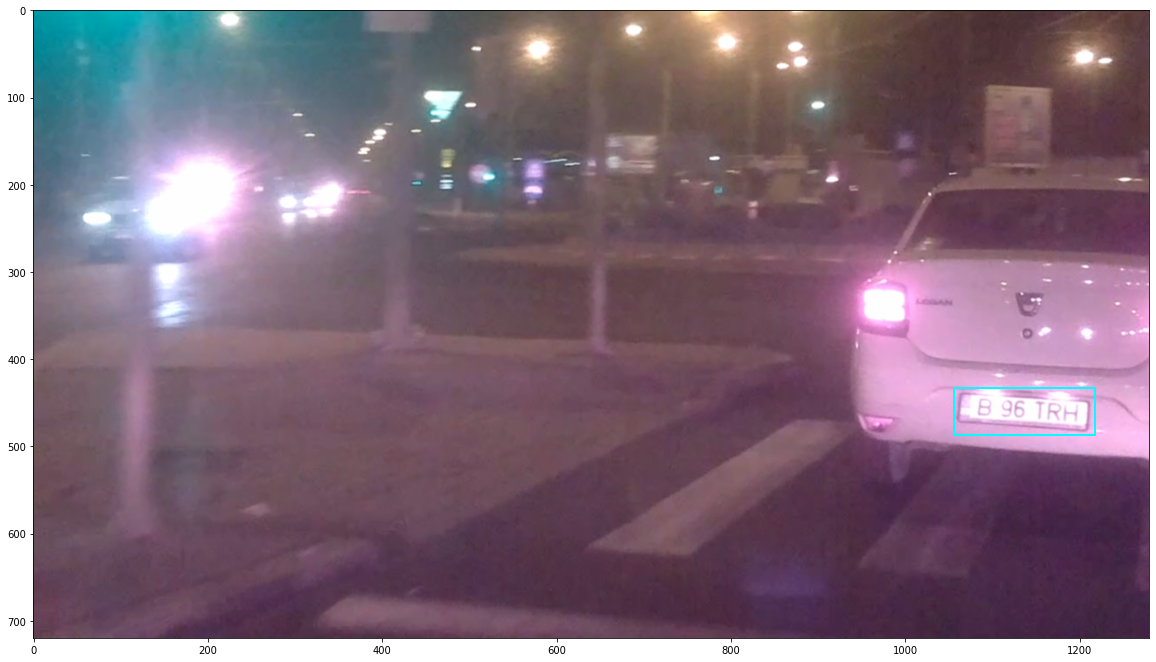

In [9]:
value = train_dataset[0]
show_image(value[0], value[1])

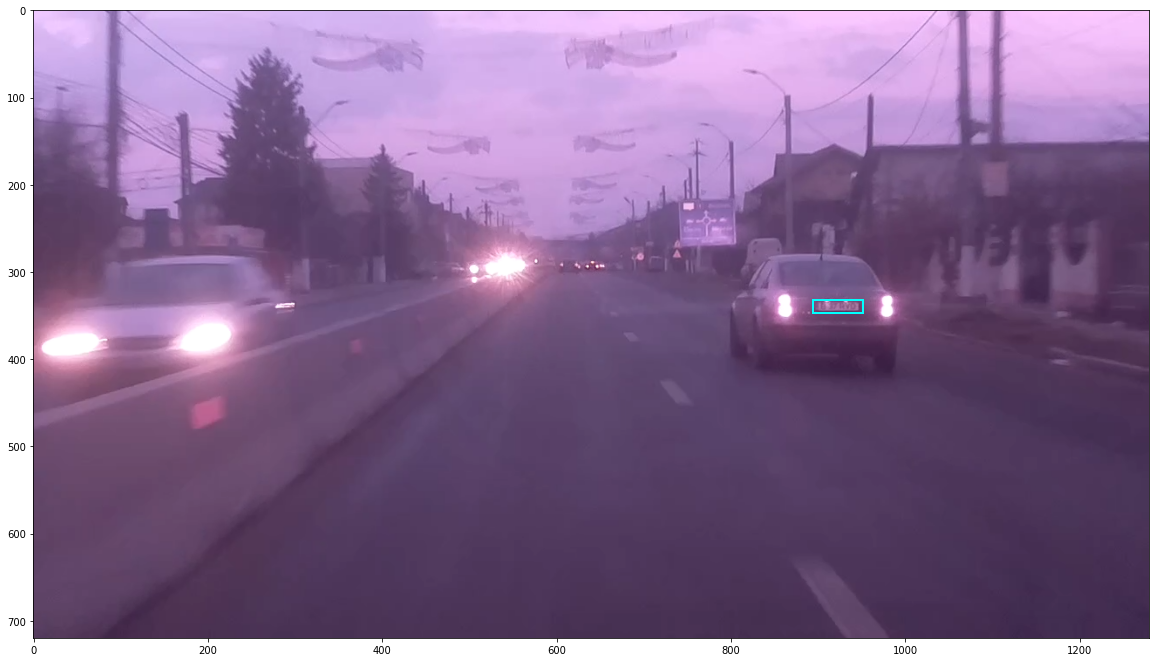

In [10]:
value = val_dataset[0]
show_image(value[0], value[1])

In [11]:
def alignment_loss(
    preds,
    targets,
    confidence_weight=0.65,
    location_weight=0.35,
    confidence_weight_virtual=0.65,
    location_weight_virtual=0.35,
    positive_weight=0.3,
    negative_weight=0.7,
):
    """
    predictions shape: 1 x (number of anchor boxes) x 5 {c, xmin, ymin, xmax, ymax}
    targets shape: 1 x (number of objects in the given image) x 4 {xmin, ymin, xmax, ymax}

    """
    preds = preds[0]
    targets = targets[0]

    locations = preds[:, 1:5]

    C_real = []
    C_virtual = []

    for target in targets:
        for pred in preds:
            location_a = target
            location_b = pred[1:]
            confidence_loss = -torch.log(pred[0] + 1e-10)
            location_loss = (((location_a - location_b) ** 2)).mean() / 100
            total_weight = confidence_weight + location_weight
            loss_real = (confidence_weight / total_weight * confidence_loss + location_weight / total_weight * location_loss)
            total_weight_virtual = confidence_weight_virtual + location_weight_virtual
            loss_virtual = (confidence_weight_virtual / total_weight_virtual * confidence_loss + location_weight_virtual / total_weight_virtual * location_loss)
            C_real.append(loss_real)
            C_virtual.append(loss_virtual)
            
    C_real = torch.stack(C_real).view(targets.shape[0], preds.shape[0])
    C_virtual = torch.stack(C_virtual).view(targets.shape[0], preds.shape[0])

    M = C_virtual.data.cpu().numpy()
    row_ind, col_ind = linear_sum_assignment(M)

    positive_losses = C_real[row_ind, col_ind]
    mask = torch.ones(preds.shape[0]).cuda()
    mask[col_ind] = 0
    negative_losses = -torch.log(1 - preds[:, 0] * mask + 1e-10)
    total_weight = positive_weight + negative_weight
    loss = (positive_weight / total_weight * positive_losses.mean() + negative_weight / total_weight * negative_losses.mean())
    return loss

In [12]:
class MultiBoxLayer(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(MultiBoxLayer, self).__init__()

        self.features = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(),

            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(256, 256, kernel_size=1),
            nn.LeakyReLU(),

            nn.Conv2d(256, 256, kernel_size=1),
            nn.LeakyReLU(),

            nn.Conv2d(256, 256, kernel_size=1),
            nn.LeakyReLU(),
            
            nn.Conv2d(256, out_channels, kernel_size=1),
        )

    def forward(self, x, image_height, image_width):
        y = self.features(x)

        b, c, h, w = y.shape

        height = image_height / h
        width = image_width / w

        dy = (torch.arange(0, h).cuda() + 0.5).view(h, 1).expand(h, w)
        dx = (torch.arange(0, w).cuda() + 0.5).view(w, 1).expand(w, h).t()

        dy = dy * height
        dx = dx * width

        C = torch.sigmoid(y[:,0,:,:])
        CX = y[:,1,:,:] * width + dx
        CY = y[:,2,:,:] * height + dy
        H = y[:,3,:,:] * height
        W = y[:,4,:,:] * width

        predictions = torch.cat([C, CX - W / 2, CY - H / 2, CX + W / 2, CY + H / 2], dim=1)

        predictions = predictions.view(b, c, h * w).permute(0, 2, 1)

        return predictions


# class Net(nn.Module):

#     def __init__(self, num_classes) -> None:
#         super(Net, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             # nn.Dropout2d(0.5),

#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             # nn.Dropout2d(0.5),

#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(384, 384, kernel_size=3, padding=1),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(384, 384, kernel_size=3, padding=1),
#             nn.LeakyReLU(),
#             # nn.Dropout2d(0.5),
#         )
#         self.multi_box = MultiBoxLayer(384, num_classes)

#     def forward(self, x) -> torch.Tensor:
#         out = self.features(x)
#         out = self.multi_box(out, x.shape[2], x.shape[3])
#         return out


def conv_batch(in_num, out_num, kernel_size=3, padding=1, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_num, out_num, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_num),
        nn.LeakyReLU())


# Residual block
class DarkResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(DarkResidualBlock, self).__init__()

        reduced_channels = int(in_channels/2)

        self.layer1 = conv_batch(in_channels, reduced_channels, kernel_size=1, padding=0)
        self.layer2 = conv_batch(reduced_channels, in_channels)

    def forward(self, x):
        residual = x

        out = self.layer1(x)
        out = self.layer2(out)
        out += residual
        return out


class Darknet53(nn.Module):
    def __init__(self, block, num_classes):
        super(Darknet53, self).__init__()

        self.num_classes = num_classes

        self.conv1 = conv_batch(3, 32)
        self.conv2 = conv_batch(32, 64, stride=2)
        self.residual_block1 = self.make_layer(block, in_channels=64, num_blocks=1)
        self.conv3 = conv_batch(64, 128, stride=2)
        self.residual_block2 = self.make_layer(block, in_channels=128, num_blocks=2)
        self.conv4 = conv_batch(128, 256, stride=2)
        self.residual_block3 = self.make_layer(block, in_channels=256, num_blocks=8)
        self.conv5 = conv_batch(256, 512, stride=2)
        self.residual_block4 = self.make_layer(block, in_channels=512, num_blocks=8)
        self.conv6 = conv_batch(512, 1024, stride=2)
        self.residual_block5 = self.make_layer(block, in_channels=1024, num_blocks=4)
        self.multi_box = MultiBoxLayer(1024, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.residual_block1(out)
        out = self.conv3(out)
        out = self.residual_block2(out)
        out = self.conv4(out)
        out = self.residual_block3(out)
        out = self.conv5(out)
        out = self.residual_block4(out)
        out = self.conv6(out)
        out = self.residual_block5(out)
        out = self.multi_box(out, x.shape[2], x.shape[3])

        return out

    def make_layer(self, block, in_channels, num_blocks):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(in_channels))
        return nn.Sequential(*layers)


def darknet53(num_classes):
    return Darknet53(DarkResidualBlock, num_classes)

In [13]:
model = darknet53(5)
model.cuda()
model.load_state_dict(torch.load('drive/MyDrive/DL/license_plate_rpn_4.pt'))

<All keys matched successfully>

In [14]:
model.eval()
val = train_dataset[99]
preds = model(val[0].unsqueeze(0).cuda())
print(preds.shape)
loss = alignment_loss(preds, val[1].unsqueeze(0).cuda())
print(loss)

torch.Size([1, 50, 5])
tensor(0.0158, device='cuda:0', grad_fn=<AddBackward0>)


In [15]:
def train(model, batch):
    model.train()
    inputs, targets = batch
    inputs = inputs.cuda()
    targets = targets.cuda()
    preds = model(inputs)
    l = alignment_loss(preds, targets)
    l.backward()
    return l

def evaluate(model, batch):
    model.eval()
    inputs, targets = batch
    inputs = inputs.cuda()
    targets = targets.cuda()
    preds = model(inputs)
    l = alignment_loss(preds, targets)
    return l

def view(model, item, show_gt=True):
    model.eval()
    inputs = item[0]
    targets = item[1]
    preds = model(inputs.unsqueeze(0).cuda()).cpu()
    # print(preds)
    
    founds = []
    for pred in preds[0]:
        if pred[0] > 0.9:
            founds.append(torch.tensor([pred[1], pred[2], pred[3], pred[4]]))

    show_image(inputs, targets, founds, show_gt)

In [18]:
LEARNING_RATE = 0.00002
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
epoches = 200

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

counter = 0
loss = torch.tensor(0).float().cuda()

for epoch in range(epoches):
    print('Epoch:', epoch + 1)
    c = 0
    for batch in train_loader:
        loss += train(model, batch)
        c += len(batch[0])
        counter += len(batch[0])
        if counter == 5:
            optimizer.step()
            optimizer.zero_grad()
            print("[%d/%d] Loss: %.5f" % (c, len(train_dataset), loss.item() / counter))
            # view(model, (batch[0].squeeze(), batch[1].squeeze(0)))
            counter = 0
            loss = torch.tensor(0).float().cuda()

    if counter > 0:
        optimizer.step()
        optimizer.zero_grad()
        print("[%d/%d] Loss: %.5f" % (c, len(train_dataset), loss.item() / counter))
        counter = 0
        loss = torch.tensor(0).float().cuda()

    loo = 0
    d = 0
    for batch in val_loader:
        l = evaluate(model, batch)
        loo += l.item()
        d += 1

    print("Val Loss: %.2f" % (loo / d))

    for i in range(5):
        item = train_dataset[random.randint(0, len(train_dataset) - 1)]
        view(model, item)

    for i in range(5):
        item = val_dataset[random.randint(0, len(val_dataset) - 1)]
        view(model, item)

    torch.save(model.state_dict(), 'drive/MyDrive/DL/license_plate_rpn_5.pt')

Epoch: 1
[5/427] Loss: 0.01578
[10/427] Loss: 0.01698
[15/427] Loss: 0.01955
[20/427] Loss: 0.02060
[25/427] Loss: 0.01947
[30/427] Loss: 0.01262
[35/427] Loss: 0.00755
[40/427] Loss: 0.02188
[45/427] Loss: 0.04106
[50/427] Loss: 0.05854
[55/427] Loss: 0.01883
[60/427] Loss: 0.00694
[65/427] Loss: 0.01298
[70/427] Loss: 0.02385
[75/427] Loss: 0.02067
[80/427] Loss: 0.02698
[85/427] Loss: 0.03269
[90/427] Loss: 0.02089
[95/427] Loss: 0.01347
[100/427] Loss: 0.01221
[105/427] Loss: 0.02834
[110/427] Loss: 0.03005
[115/427] Loss: 0.02658
[120/427] Loss: 0.01300
[125/427] Loss: 0.01073
[130/427] Loss: 0.01466
[135/427] Loss: 0.01186
[140/427] Loss: 0.01510
[145/427] Loss: 0.02145
[150/427] Loss: 0.02114
[155/427] Loss: 0.01007
[160/427] Loss: 0.01266
[165/427] Loss: 0.00650
[170/427] Loss: 0.01283
[175/427] Loss: 0.02352
[180/427] Loss: 0.01174
[185/427] Loss: 0.01325
[190/427] Loss: 0.01396
[195/427] Loss: 0.00662
[200/427] Loss: 0.02226
[205/427] Loss: 0.00503
[210/427] Loss: 0.00364
[21

KeyboardInterrupt: ignored

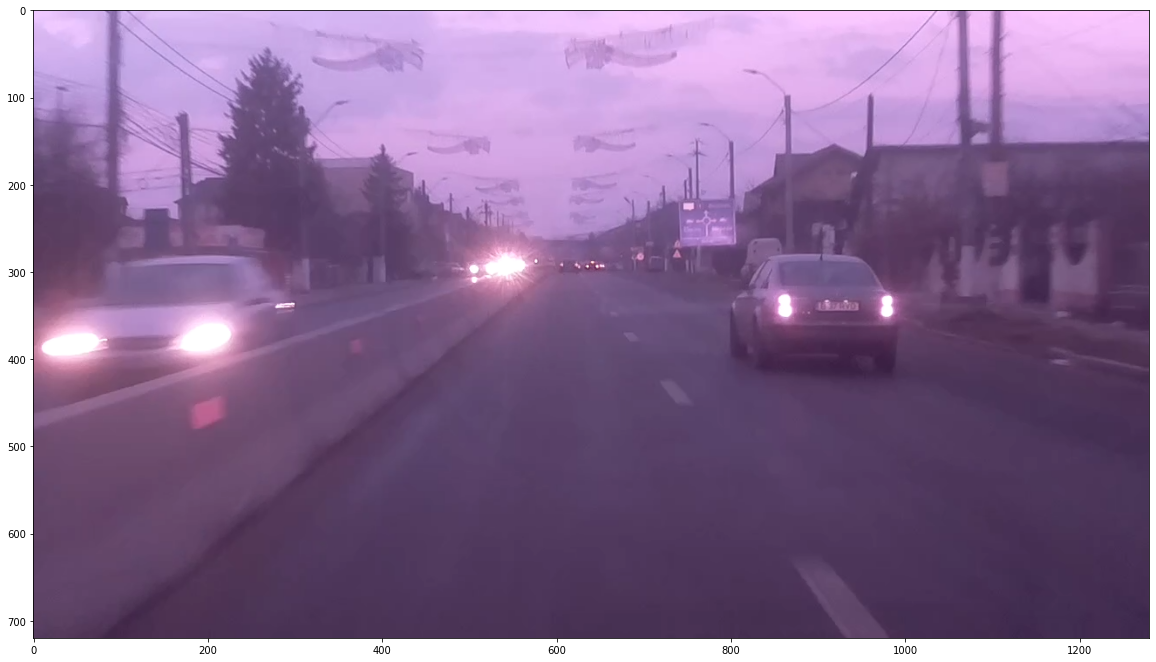

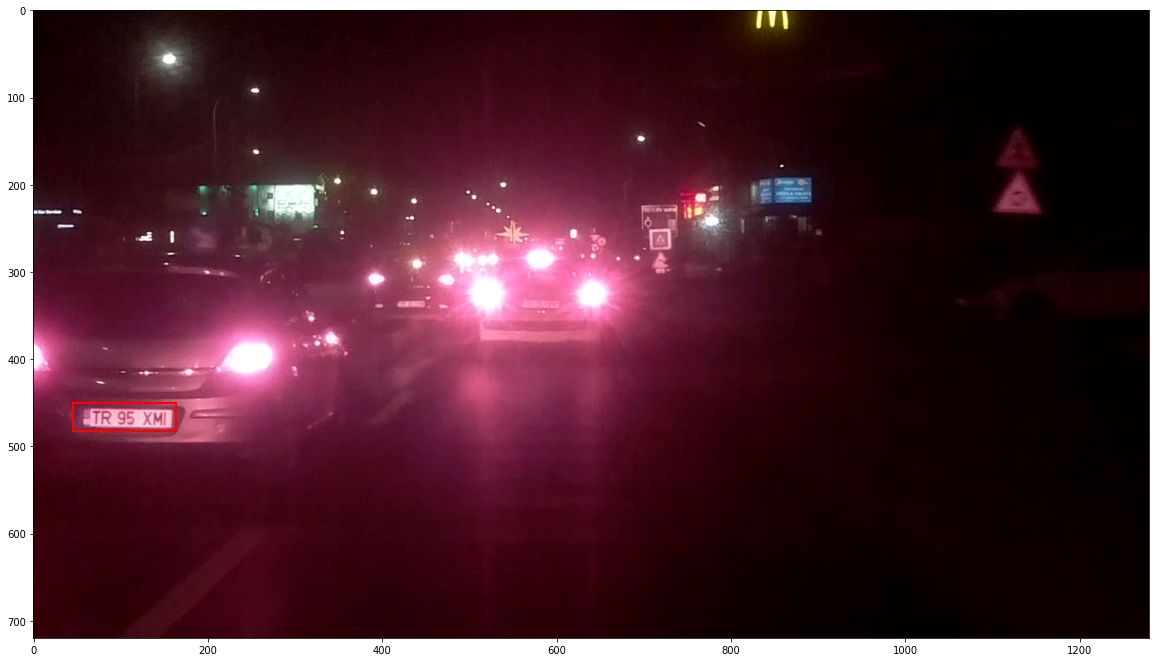

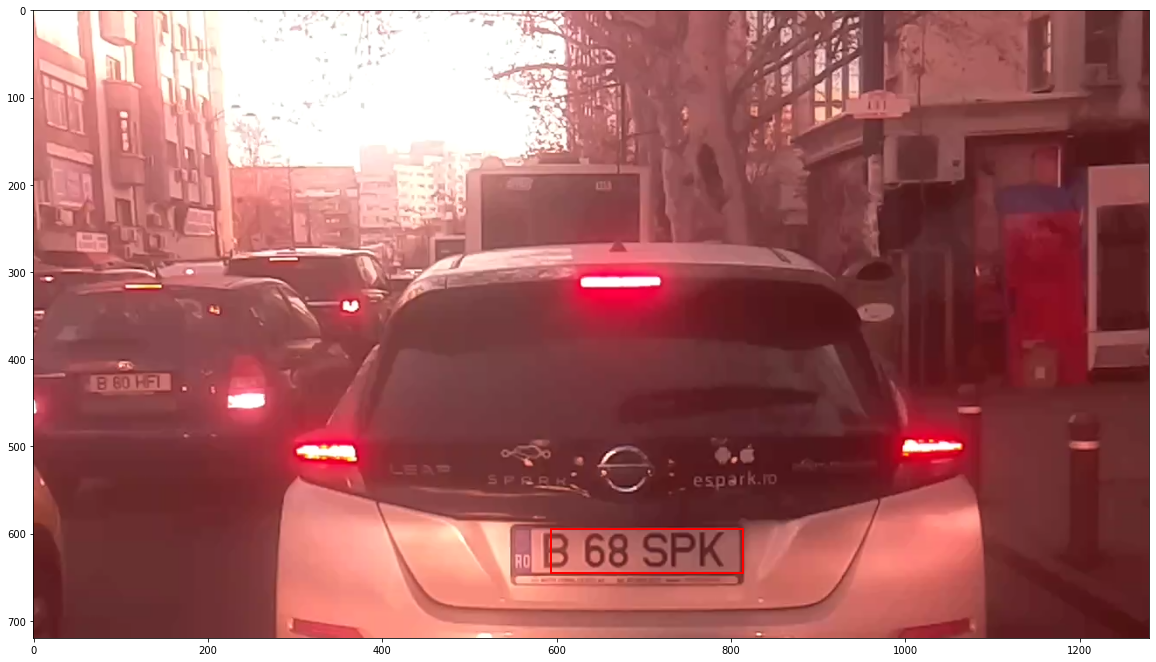

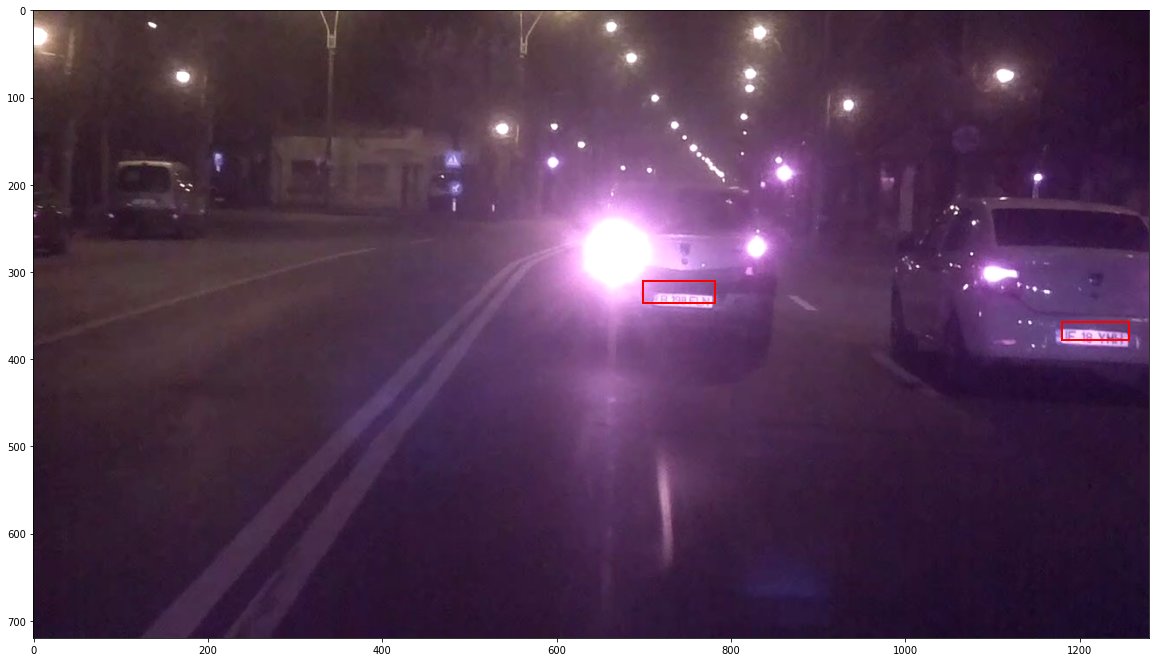

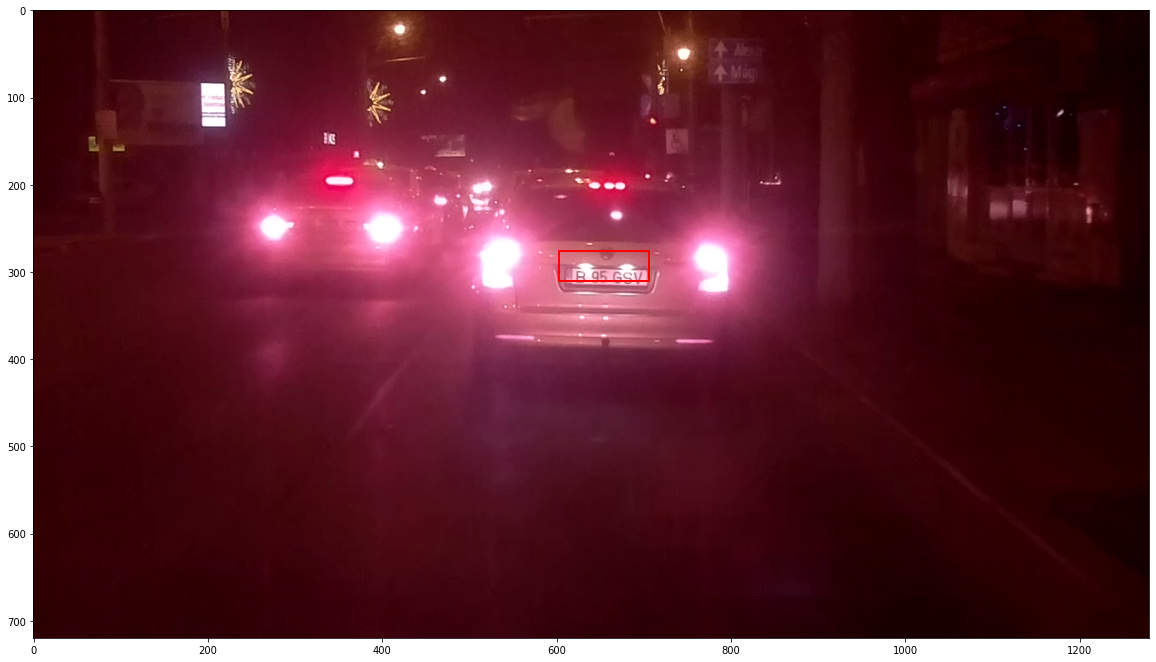

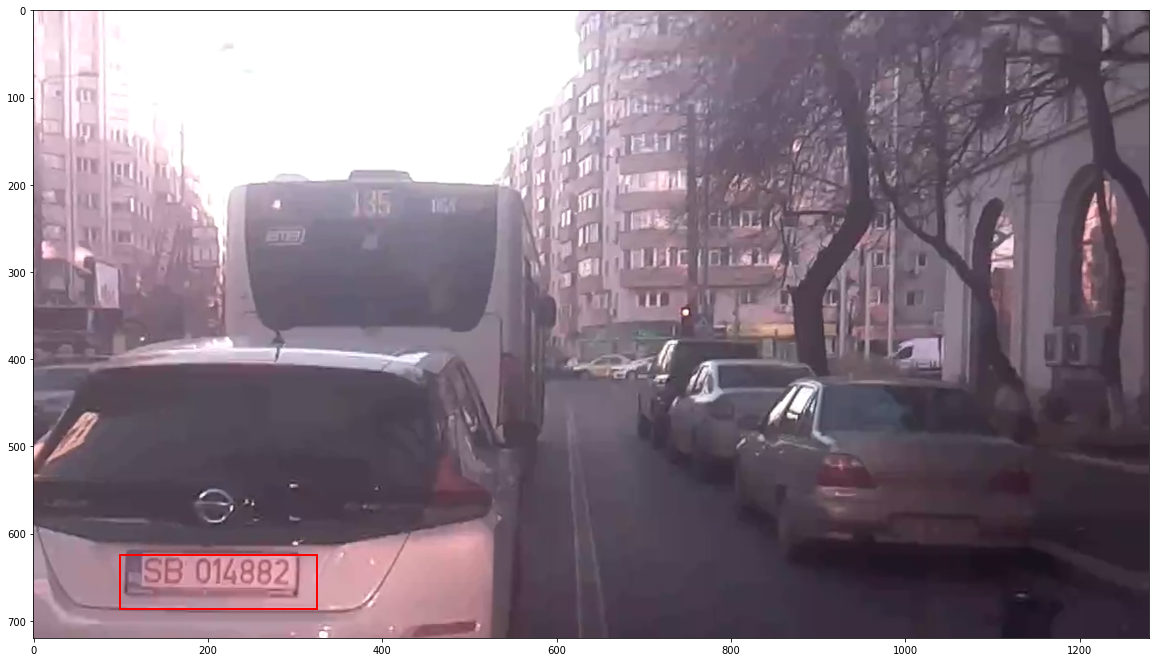

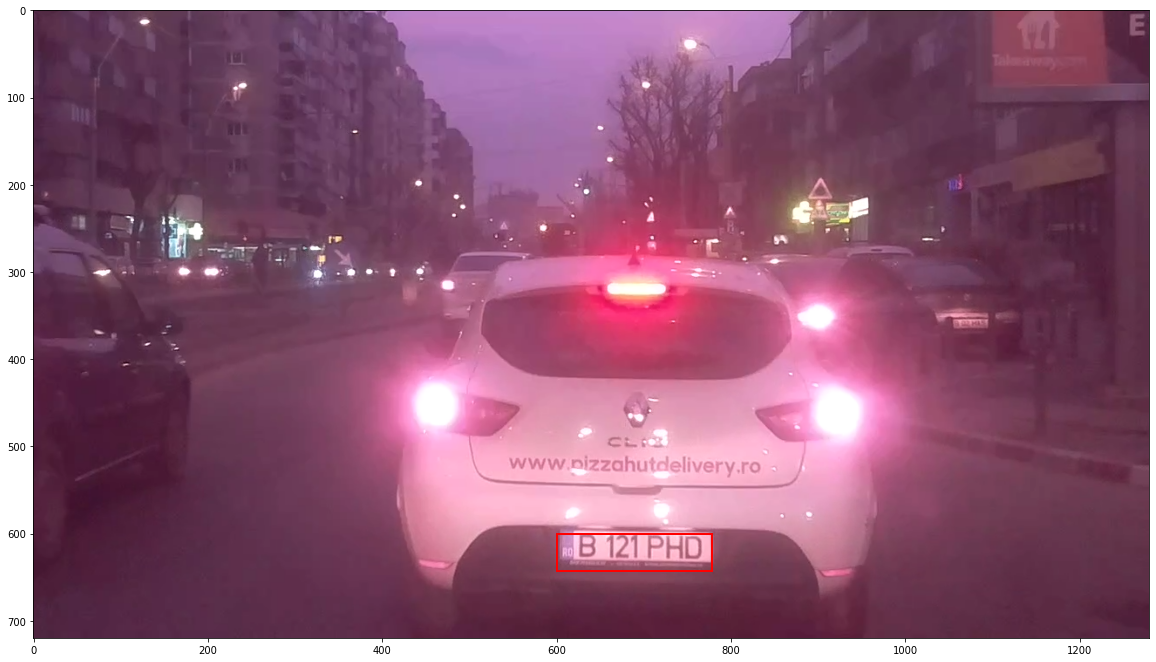

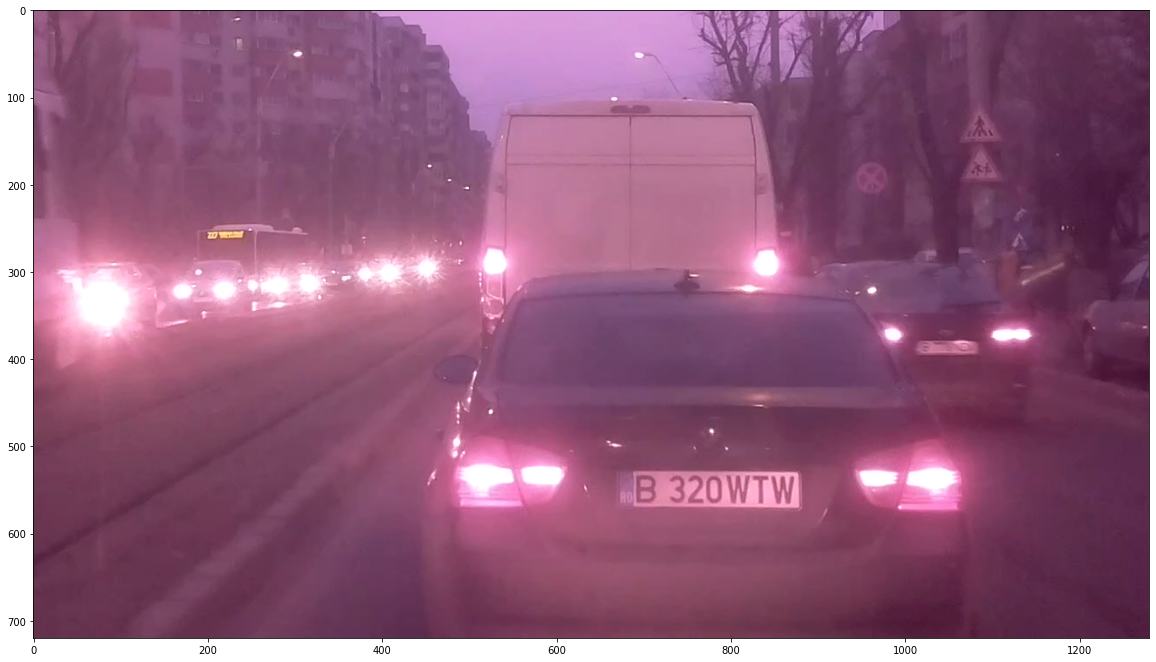

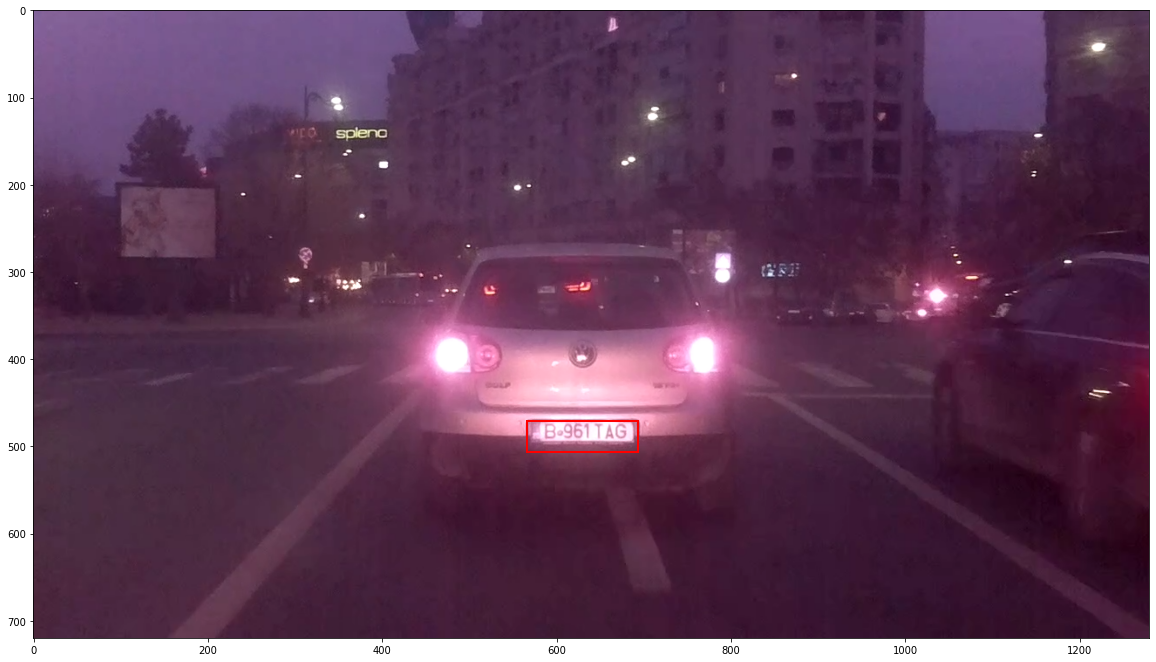

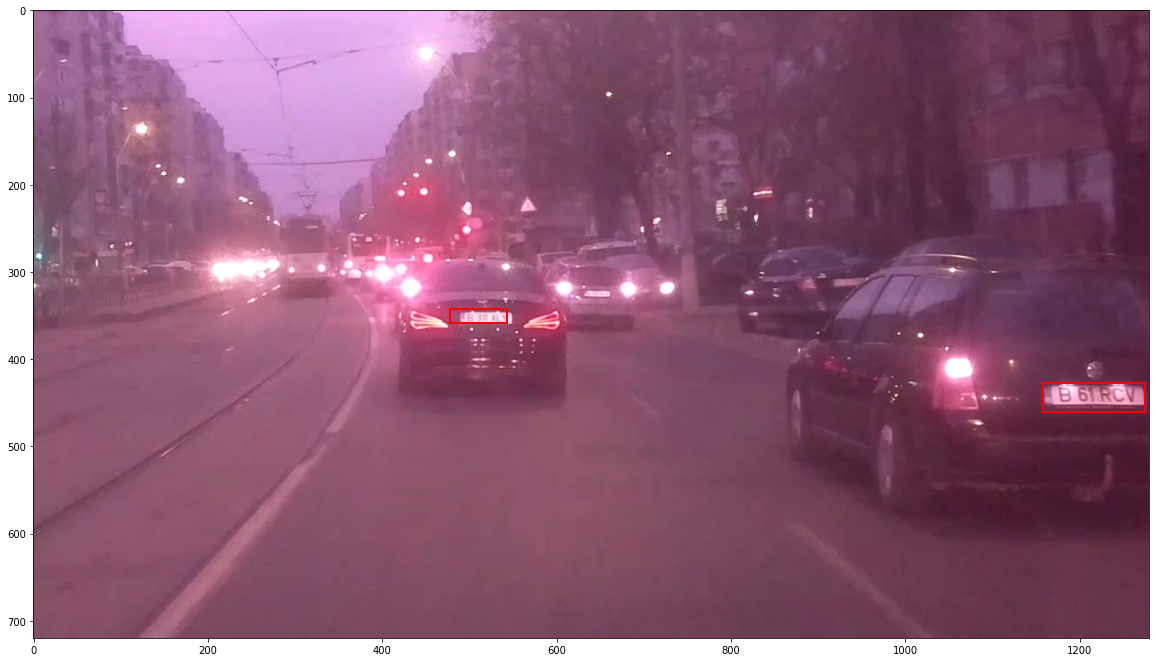

In [19]:
for i in range(10):
    view(model, val_dataset[i], show_gt=False)